## AlphaTims

In [290]:
import os
import re
import numba
import numpy as np
import pandas as pd
import panel as pn

import colorcet
import hvplot.pandas
import holoviews as hv
from holoviews import opts
from bokeh.models import HoverTool
from bokeh.plotting import figure

# pn.extension('bokeh')


In [291]:
css = '''
.bk.opt {
    position: relative;
    display: block;
    left: 75px;
    top: 0px;
    width: 80px;
    height: 80px;
}

h1 {
    color: #045082;
    font-size: 45px;
    line-height: 0.6;
    text-align: center;
}

h2 {
    color: #045082;
    text-align: center;
}

.bk.main-part {
    background-color: #EAEAEA;
    font-size: 17px;
    line-height: 23px;
    letter-spacing: 0px;
    font-weight: 500;
    color: #045082;
    text-align: center;
    position: relative !important;
    margin-left: auto;
    margin-right: auto;
    width: 40%;
}

.bk-root .bk-btn-primary {
    background-color: #045082;
    font-size: 11px;
    font-weight: 700;
    text-transform: uppercase;
    letter-spacing: 1.5px;
}

.bk-root .bk-btn-default {
    font-size: 11px;
    font-weight: 700;
    text-transform: uppercase;
    letter-spacing: 1.5px;
}

.bk.alert-danger {
    background-color: #EAEAEA;
    color: #c72d3b;
    border: 0px #EAEAEA solid;
    padding: 0;
}

.bk.alert-success {
    background-color: #EAEAEA;
    border: 0px #EAEAEA solid;
    padding: 0;
}

.settings {
    background-color: #EAEAEA;
    border: 2px solid #045082;
}

.bk.card-title {
    font-size: 13px;
    font-weight: initial;
}

'''
pn.extension(raw_css=[css])

In [292]:
### LOCAL VARIABLES

DATASET = None
whole_title = str()

In [293]:
### HEADER

header_titel = pn.pane.Markdown(
    '# AlphaTims', 
    width=1250
)
mpi_biochem_logo = pn.pane.PNG(
    '../alphatims/img/mpi_logo.png', 
    link_url='https://www.biochem.mpg.de/en', 
    width=60, 
    height=60,
    align='start'
)
mpi_logo = pn.pane.JPG(
    '../alphatims/img/max-planck-gesellschaft.jpg', 
    link_url='https://www.biochem.mpg.de/en',
    height=62,
    embed=True,
    width=62,
    margin=(5, 0, 0, 5),
    css_classes=['opt']
)
github_logo = pn.pane.PNG(
    '../alphatims/img/github.png',
    link_url='https://github.com/MannLabs/alphatims',
    height=70,
)

header = pn.Row(
    mpi_biochem_logo,
    mpi_logo,
    header_titel,
    github_logo,
    height=73
)

In [294]:
### MAIN PART

project_description = pn.pane.Markdown(
    """### AlphaTIMS is an open-source Python package for fast accessing Bruker TimsTOF data. It provides a very efficient indexed data structure that allows to access four-dimensional TIMS-time of flight data in the standard numerical python (NumPy) manner. AlphaTIMS is a key enabling tool to deal with the large and high dimensional TIMS data.""",
    margin=(10, 0, 0, 0), 
    css_classes=['main-part'], 
    width=615
)

divider_descr = pn.pane.HTML(
    '<hr style="height: 6px; border:none; background-color: #045082; width: 1140px">', 
    width=1510, 
    align='center'
)

upload_file = pn.widgets.TextInput(
    name='Specify an experimental file:',
    placeholder='Enter the whole path to Bruker .d folder or .hdf file',
    width=800,
    margin=(15,15,0,15) 
)

upload_button = pn.widgets.Button(
    name='Upload  Data', 
    button_type='primary', 
    height=31,
    width=100,
    margin=(34,20,0,20)
)

upload_spinner = pn.indicators.LoadingSpinner(
    value=False,
    bgcolor='light',
    color='secondary',
    margin=(30,15,0,15),
    width=40, 
    height=40
)

upload_error = pn.pane.Alert(
    width=400,
    alert_type="danger", 
    margin=(-15,0,10,200),
)

exit_button = pn.widgets.Button(
    name='Quit',
    button_type='primary',
    height=31,
    width=100,
    margin=(34,20,0,0)
)

main_part = pn.Column(
    project_description,
    divider_descr,
    pn.Row(
        upload_file,
        upload_button,
        upload_spinner,
        exit_button,
        align='center'
    ),
    upload_error,
    background='#eaeaea',
    width=1510,
    height=360,
    margin=(5, 0, 10, 0)
)

In [295]:
### SETTINGS

settings_title = pn.pane.Markdown(
    '## Parameters',
    align='center', 
    margin=(10,0,0,0)
)

settings_divider = pn.pane.HTML(
    '<hr style="height: 3.5px; border:none; background-color: #045082; width: 440px;">', 
    align='center',
    margin=(0, 10, 0, 10)
)

sliders_divider = pn.pane.HTML(
    '<hr style="height: 1.5px; border:none; background-color: black; width: 425px;">', 
    align='center',
    margin=(10, 10, 0, 10)
)

selectors_divider = pn.pane.HTML(
    '<hr style="border-left: 2px solid black; height: 50px;">', 
    align='center',
    margin=(-5, 0, 0, 40)
)

# save to hdf

save_hdf_button = pn.widgets.Button(
    name='Save to HDF',
    button_type='default',
    height=31,
    width=200,
    margin=(15,0,0,120)
)

save_spinner = pn.indicators.LoadingSpinner(
    value=False,
    bgcolor='light',
    color='secondary',
    margin=(15,15,0,15),
    width=30, 
    height=30
)

save_message = pn.pane.Alert(
    alert_type='success',
    margin=(-10,15,20,85),
    width=300
)

# frames/RT selection

frame_slider = pn.widgets.IntRangeSlider(
#     name='Frames',
    show_value=False,
    bar_color='#045082',
    start=1,
    step=1,
    margin=(10,20,10,20)
)

frames_start = pn.widgets.IntInput(
    name='Start frame',  
    value=1,
    step=1, 
    start=1,
    width=80,
    margin=(0,0,0,0)
)

rt_start = pn.widgets.FloatInput(
    name='Start RT(min)',  
    value=0.00,
    step=0.50, 
    start=0.00,
    width=80,
    format='0,0.000',
    margin=(0,0,0,20),
    disabled=True
)

frames_end = pn.widgets.IntInput(
    name='End frame', 
    value=1, 
    step=1, 
    start=1,
    width=80,
    margin=(0,0,0,0)
)

rt_end = pn.widgets.FloatInput(
    name='End RT(min)',  
    step=0.50, 
    start=0.00,
    width=80,
    format='0,0.000',
    margin=(0,0,0,20),
    disabled=True
)


# scans/IM selection
scan_slider = pn.widgets.IntRangeSlider(
#     name='Scans',
    show_value=False,
    bar_color='#045082',
    start=1,
    step=1,
    margin=(5, 20)
)

scan_start = pn.widgets.IntInput(
    name='Start scan',  
    value=1,
    step=1, 
    start=1,
    width=80,
    margin=(0,0,0,0)
)

im_start = pn.widgets.FloatInput(
    name='Start IM',  
#     value=0.00,
    step=0.10, 
#     start=0.00,
    width=80,
    format='0,0.000',
    margin=(0,0,0,20),
    disabled=True
)

scan_end = pn.widgets.IntInput(
    name='End scan', 
    step=1, 
    start=1,
    width=80,
    margin=(0,0,0,0)
)

im_end = pn.widgets.FloatInput(
    name='End IM',  
    step=0.10, 
#     start=0.00,
    width=80,
    format='0,0.000',
    margin=(0,0,0,20),
    disabled=True
)

# tof and m/z selection

tof_slider = pn.widgets.IntRangeSlider(
#     name='TOF',
    show_value=False,
    bar_color='#045082',
    start=1,
    step=1,
    margin=(5, 20)
)

tof_start = pn.widgets.IntInput(
    name='Start TOF',  
    value=1,
    step=1, 
    start=1,
    width=80,
    margin=(0,0,0,0)
)

mz_start = pn.widgets.FloatInput(
    name='Start m/z',  
    value=0.00,
    step=0.10, 
    start=0.00,
    width=80,
    format='0.00',
    margin=(0,0,0,20),
    disabled=True
)

tof_end = pn.widgets.IntInput(
    name='End TOF', 
    value=2, 
    step=1, 
    start=1,
    width=80,
    margin=(0,0,0,0)
)

mz_end = pn.widgets.FloatInput(
    name='End m/z',  
    step=0.10, 
    start=0.00,
    width=85,
    format='0.00',
    margin=(0,0,0,20),
    disabled=True
)

# quad info
quad_slider = pn.widgets.RangeSlider(
#     name='Quad',
    show_value=False,
    bar_color='#045082',
    start=0,
    value=(0, 0),
    step=1,
    margin=(5, 20),
    disabled=True
)

select_precursors = pn.widgets.Checkbox(
    name='Show MS1 precursors',
    value=True,
    width=200,
    margin=(25,20,0,20),  
)

quad_start = pn.widgets.FloatInput(
    name='Start QUAD',  
    value=0.00,
    step=0.50, 
    start=0.00,
    width=80,
    format='0.00',
    margin=(0,0,20,0),
    disabled=True
)

quad_end = pn.widgets.FloatInput(
    name='End QUAD',  
    value=0.00,
    step=0.50, 
    start=0.00,
    width=80,
    format='0.00',
    margin=(0,0,20,20),
    disabled=True
) 

intensity_threshold = pn.widgets.IntInput(
    name='Intensity threshold', 
    value=0,
    width=106,
    margin=(5, 43, 15, 60),
)

selection_actions = pn.pane.Markdown(
    'Selected settings:',
    align='center',
    margin=(-18,0,0,0)
)
undo_button = pn.widgets.Button(
    name='\u21b6',
#     button_type='primary',
    height=32,
    width=50,
    margin=(-3,20,0,20)
)
redo_button = pn.widgets.Button(
    name='↷',
#     button_type='primary',
    height=32,
    width=50,
    margin=(-3,20,0,0)
)

def export_sliced_data():
    from io import StringIO
    if select_precursors.value:
        quad_values = (-1, 1)
    else:
        quad_values = quad_slider.value
    df = DATASET[
        slice(*frame_slider.value), 
        slice(*scan_slider.value), 
        slice(*quad_values), 
        slice(*tof_slider.value),
        intensity_threshold.value:,
        'df'
    ]
    sio = StringIO()
    df.to_csv(sio, index=False)
    sio.seek(0)
    return sio

download_selection = pn.widgets.FileDownload(
    callback=export_sliced_data, 
    filename=f'sliced_data.csv',
    button_type='default',
    height=31,
    width=250,
    margin=(5, 20, 15, 20),
    align='center'
)

# player
player_title = pn.pane.Markdown(
    "Quick Data Overview",
    align='center',
    margin=(-5,0,-20,0)
)
player = pn.widgets.DiscretePlayer(
    interval=1800,
    value=1, 
    show_loop_controls=True,
    loop_policy='once',
    width=430,
    align='center'
)

In [296]:
# select axis

card_divider = pn.pane.HTML(
    '<hr style="height: 1.5px; border:none; background-color: black; width: 415px;">', 
    align='center',
    margin=(10, 10, 5, 10)
)

# plot 1
plot1_title = pn.pane.Markdown(
    '#### Axis for Heatmap',
    margin=(10,0,-5,0),
    align='center'
)
plot1_x_axis = pn.widgets.Select(
    name='X axis', 
    value='m/z, Th',
    options=['m/z, Th', 'Inversed IM, V·s·cm\u207B\u00B2', 'RT, min'],
    width=180,
    margin=(0,20,0,20),
)
plot1_y_axis = pn.widgets.Select(
    name='Y axis', 
    value='Inversed IM, V·s·cm\u207B\u00B2',
    options=['m/z, Th', 'Inversed IM, V·s·cm\u207B\u00B2', 'RT, min'],
    width=180,
    margin=(0,20,0,10),
)

# plot 2
plot2_title = pn.pane.Markdown(
    '#### Axis for XIC/Spectrum/Mobilogram',
    align='center',
    margin=(-10,0,-5,0),
)
plot2_x_axis = pn.widgets.Select(
    name='X axis', 
    value='Inversed IM, V·s·cm\u207B\u00B2',
    options=['RT, min', 'm/z, Th', 'Inversed IM, V·s·cm\u207B\u00B2'],
    width=180,
    margin=(0,20,0,20),
)
plot2_y_axis = pn.widgets.Select(
    name='Y axis', 
    value='Intensity',
    options=['Intensity'],
#     options=['RT, min', 'm/z, Th', 'Inversed IM, V·s·cm\u207B\u00B2', 'Intensity'],
    width=180,
    margin=(0,20,0,10),
)

change_axis = pn.widgets.Button(
    name='Change Axis',
    button_type='default',
    height=31,
    width=200,
    align='center',
    margin=(15,0,-10,0)
)

axis_selection = pn.Card(
    plot1_title,
    pn.Row(
        plot1_x_axis,
        plot1_y_axis
    ),
    card_divider,
    plot2_title,
    pn.Row(
        plot2_x_axis,
        plot2_y_axis
    ),
    card_divider,
    change_axis,
    title='Select axis for plots',
    collapsed=True,
    width=430,
    margin=(20, 10, 10, 17),
    background='#EAEAEA',
    header_background='EAEAEA',
    css_classes=['axis_selection_settings']
)

In [297]:
### putting together all settings widget 
settings = pn.Column(
    settings_title,
    settings_divider,
    pn.Row(
        save_hdf_button,
        save_spinner
    ),
    save_message,
    axis_selection,
    player_title,
    player,
    sliders_divider,
    frame_slider,
    pn.Row(
        frames_start,
        rt_start,
        selectors_divider,
        frames_end,
        rt_end,
        align='center',
    ),
    sliders_divider,
    scan_slider,
    pn.Row(
        scan_start,
        im_start,
        selectors_divider,
        scan_end,
        im_end,
        align='center',
    ),
    sliders_divider,
    tof_slider,
    pn.Row(
        tof_start,
        mz_start,
        selectors_divider,
        tof_end,
        mz_end,
        align='center',
    ),
    sliders_divider,
    quad_slider,
    pn.Row(
        select_precursors,
        quad_start,
        quad_end
    ),
    sliders_divider,
    pn.Row(
        intensity_threshold,
        selectors_divider,
        pn.Column(
            selection_actions,
            pn.Row(
                undo_button,
                redo_button
            )
        ),
    ),
    sliders_divider,
    download_selection,
    width=460,
    align='center',
    margin=(0,0,0,0),
    css_classes=['settings']
) 

In [298]:
### plotting options
hover = HoverTool(
    tooltips=[('RT, min', '@RT'), ('Intensity', '@SummedIntensities')], 
    mode='vline'
)
chrom_opts = opts.Curve(
    width=1000, 
    height=310, 
    xlabel='RT, min', 
    ylabel='Intensity',
    line_width=1, 
    yformatter='%.1e', 
    shared_axes=True,
    tools=[hover]
)

vspan_opts = opts.VSpan(
    color='red', 
    apply_ranges=True,
    alpha=0.6,
    line_width=1
)

In [299]:
### JS callbacks
axis_selection.jscallback(
    collapsed=""" 
        var $container = $("html,body");
        var $scrollTo = $('.axis_selection_settings');

        $container.animate({scrollTop: $container.offset().top + $container.scrollTop(), scrollLeft: 0},300);
        """, 
    args={'card': axis_selection}
);

In [300]:
### FUNCTIONS
# preload data
@pn.depends(
    upload_button.param.clicks,
    watch=True
)
def upload_data(_):
    import sys
    sys.path.append('../')
    import alphatims.bruker
    global DATASET
    global whole_title
    if upload_file.value.endswith(".d") or upload_file.value.endswith(".hdf"):
        ext = os.path.splitext(upload_file.value)[-1]
        if ext == '.d':
            save_hdf_button.disabled = False
            save_message.object = ''
        elif ext == '.hdf':
            save_hdf_button.disabled = True
            save_message.object = ''
        upload_error.object = None
        if DATASET and os.path.basename(DATASET.bruker_d_folder_name).split('.')[0] \
        == os.path.basename(upload_file.value).split('.')[0]:
            upload_error.object = '#### This file is already uploaded.'
        elif not DATASET or os.path.basename(DATASET.bruker_d_folder_name).split('.')[0] \
        != os.path.basename(upload_file.value).split('.')[0]:
            try:
                upload_spinner.value = True
                DATASET = alphatims.bruker.TimsTOF(
                    upload_file.value
                )
                mode = ''
                if 'DDA' in upload_file.value:
                    mode = 'dda-'
                elif 'DIA' in upload_file.value:
                    mode = 'dia-'
                whole_title = str(DATASET.meta_data['SampleName']) + ext + ': ' + mode + str(DATASET.acquisition_mode)
            except ValueError as e:
                print(e)
                upload_error.object = "#### This file is corrupted and can't be uploaded."
    else:
        upload_error.object = '#### Please, specify a path to .d Bruker folder or .hdf file.'

# save data        
@pn.depends(
    save_hdf_button.param.clicks,
    watch=True
)
def save_hdf(_):
    save_message.object = ''
    save_spinner.value = True
    file_name = os.path.basename(DATASET.bruker_d_folder_name).split('.')[0] + '.hdf'
    directory = DATASET.bruker_d_folder_name
    DATASET.save_as_hdf(
        overwrite=True,
        directory=directory,
        file_name=file_name,
        compress=False,
    )
    save_spinner.value = False
    save_message.object = '#### The HDF file is successfully saved outside .d folder.'
    
### PLOTTING
def visualize_chrom():
    data = DATASET.frames.query('MsMsType == 0')[['Time', 'SummedIntensities']]
    data['RT'] = data['Time'] / 60
    chrom = hv.Curve(
        data=data, 
        kdims=['RT'],
        vdims=['SummedIntensities']
    ).opts(
        chrom_opts,
        opts.Curve(
            title="Chromatogram - " + whole_title
        )
    )
    # implement the selection
    bounds_x = hv.streams.BoundsX(source=chrom, boundsx=(rt_start.value, rt_end.value))
    def get_range_func(color):
        def _range(boundsx):
            y = 0
            x = boundsx[0]
            rt_start.value = boundsx[0]
            rt_end.value = boundsx[1]
            return hv.VSpan(boundsx[0], boundsx[1]).opts(color=color)
        return _range
    dmap = hv.DynamicMap(get_range_func('orange'), streams=[bounds_x])
    fig = chrom * dmap
    return fig.opts(responsive=True)

def visualize_scatter(
    selected_indices
):
    labels = {
        'mz_values': 'm/z, Th',
        'rt_values': 'RT, min',
        'mobility_values': 'Inversed IM, V·s·cm\u207B\u00B2',
        'intensity_values': 'Intensity'
    }
    x_coor = [k for k, v in labels.items() if v == plot1_x_axis.value][0]
    y_coor = [k for k, v in labels.items() if v == plot1_y_axis.value][0]
    z_coor = "intensity_values"
    df = DATASET.as_dataframe(selected_indices)
    scatter = df.hvplot.scatter(
        x=x_coor,
        y=y_coor,
        c=z_coor,
        xlabel=labels[x_coor],
        ylabel=labels[y_coor],
        ylim=(
            df[y_coor].min(),
            df[y_coor].max()
        ),
        xlim=(
            df[x_coor].min(),
            df[x_coor].max()
        ),
        title='Heatmap - ' + whole_title,
        tools=['hover'],
        datashade=True,
        dynspread=True,
        cmap=colorcet.fire,
        clabel=z_coor,
        nonselection_color='green',
        selection_color='blue',
        color="white",
        width=1000, 
        height=300, 
    )
    return scatter


def visualize_spectrum(
    selected_indices
):
    labels = {
        'mz_values': 'm/z, Th',
        'rt_values': 'RT, min',
        'mobility_values': 'Inversed IM, V·s·cm\u207B\u00B2',
        'intensity_values': 'Intensity'
    }
    x_coor = [k for k, v in labels.items() if v == plot2_x_axis.value][0]
    y_coor = [k for k, v in labels.items() if v == plot2_y_axis.value][0]
    df = DATASET.as_dataframe(selected_indices)
    if x_coor == 'mz_values':
        mz_intensities = DATASET.bin_intensities(selected_indices, ['mz'])
        spectrum = hv.Spikes(
            (
                sorted(df[x_coor].unique()), 
                mz_intensities[mz_intensities>0]
            ), 
            labels[x_coor], 
            labels[y_coor])
        spectrum.opts(
            title='Spectrum - ' + whole_title,
            tools=['hover'], 
            color='Intensity',
            cmap=colorcet.kb,
            width=1000, 
            height=300,  
            align='center', 
        )
    elif x_coor == 'mobility_values':
        im_intensities = DATASET.bin_intensities(selected_indices, ['mobility'])
        spectrum = hv.Curve(
            (
                sorted(df[x_coor].unique(), reverse=True),
                im_intensities[im_intensities > 0]
            ),
            labels[x_coor], 
            labels[y_coor]
        )
        spectrum.opts(
            title="Mobilogram - " + whole_title,
            width=1000, 
            height=300, 
            align='center', 
            line_width=1,
            yformatter='%.1e',
            tools=['hover'] 
        )
    elif x_coor == 'rt_values':
        rt_intensities = DATASET.bin_intensities(selected_indices, ['rt'])
        spectrum = hv.Curve(
            (
                sorted(df[x_coor].unique()/60),
                rt_intensities[rt_intensities > 0]   
            ),
            labels[x_coor], 
            labels[y_coor]
        )
        spectrum.opts(
            title="XIC - " + whole_title,
            width=1000, 
            height=300, 
            color='darkred',
            align='center', 
            line_width=1,
            yformatter='%.1e',
            tools=['hover']
        )
    return spectrum


### SHOW SETTINGS/PLOTS

@pn.depends(
    upload_button.param.clicks
)        
def show_settings(_):
    if DATASET:
        frame_slider.end = frames_start.end = frames_end.end = player.end = DATASET.frame_max_index
        step = len(DATASET.frames.query('MsMsType == 0')) // 10
        player.options = DATASET.frames.query('MsMsType == 0').loc[1::step, 'Id'].to_list()
        frame_slider.value = (1,2)
        rt_start.end = rt_end.end = max(DATASET.rt_values)/60
        # scan end should be DATASET.scan_max_index == 927 + 1
        scan_slider.end = scan_start.end = scan_end.end = DATASET.scan_max_index + 1
        scan_slider.value = (scan_slider.start, scan_slider.end)
        im_start.end = im_end.end = max(DATASET.mobility_values)
        im_start.start = im_end.start = min(DATASET.mobility_values)
        im_start.value = max(DATASET.mobility_values)
        im_end.value = min(DATASET.mobility_values)
        quad_slider.end = round(max(DATASET.quad_high_values), 3)
        tof_slider.end = int(DATASET.tof_max_index + 1)
        tof_slider.value = (tof_slider.start, tof_slider.end)
        upload_spinner.value = False
        return settings
    else:
        return None
    
### ALL SLIDER DEPENDENCIES

### FRAMES + RT
@pn.depends(
    frame_slider.param.value,
    watch=True
)
def update_frames_rt_using_slider(
    slider_values,
):
    frames_start.value, frames_end.value = slider_values
    try:
        rt_start.value, rt_end.value = DATASET.rt_values[[slider_values[0], slider_values[1]]] / 60
    except IndexError:
        # happens in the case when we specify the last frame and her index will be existing_frame+1 and therefore,
        # there is no RT for this - solution: to show the last RT 
        rt_start.value, rt_end.value = DATASET.rt_values[[slider_values[0], slider_values[1]-1]] / 60

@pn.depends(
    frames_start.param.value,
    watch=True
)
def update_frames_rt_using_frames_start(
    frames_start_values
): 
    if frames_start_values > frames_end.value:
        frames_end.value = frames_start.value
    frame_slider.value = (frames_start.value, frames_end.value)
    
@pn.depends(
    frames_end.param.value,
    watch=True
)
def update_frames_rt_using_frames_end(
    frames_end_values
): 
    if frames_end_values < frames_start.value:
        frames_start.value = frames_end.value
    frame_slider.value = (frames_start.value, frames_end.value)
        
# @pn.depends(
#     rt_start.param.value,
#     watch=True
# )
# def update_frames_rt_using_rt_start(
#     rt_start_values
# ): 
#     if rt_start_values > rt_end.value:
#         rt_end.value = rt_start_values
#     frames_start.value = int(np.where(np.isclose(DATASET.rt_values, rt_start_values * 60, atol=0.05))[0][0])
    
# @pn.depends(
#     rt_end.param.value,
#     watch=True
# )
# def update_frames_rt_using_rt_end(
#     rt_end_values
# ): 
#     if rt_end_values < rt_start.value:
#         rt_start.value = rt_end_values
#     frames_end.value = int(np.where(np.isclose(DATASET.rt_values, rt_end_values * 60, atol=0.05))[0][0])
    
### SCANS + IM

@pn.depends(
    scan_slider.param.value,
    watch=True
)
def update_scan_im_using_slider(
    slider_values,
):
    scan_start.value, scan_end.value = slider_values
    try:
        im_start.value, im_end.value = DATASET.mobility_values[[scan_slider.value[0] - 1, scan_slider.value[1] - 1]]
    except IndexError:
        im_start.value, im_end.value = DATASET.mobility_values[[scan_slider.value[0] - 1, scan_slider.value[1] - 2]]
    
@pn.depends(
    scan_start.param.value,
    watch=True
)
def update_scan_im_using_scans_start(
    scan_start_values
): 
    if scan_start_values > scan_end.value:
        scan_end.value = scan_start.value
    scan_slider.value = (scan_start.value, scan_end.value)
    
@pn.depends(
    scan_end.param.value,
    watch=True
)
def update_scan_im_using_scans_end(
    scan_end_values
): 
    if scan_end_values < scan_start.value:
        scan_start.value = scan_end.value
    scan_slider.value = (scan_start.value, scan_end.value)


### TOF + m/z

@pn.depends(
    tof_slider.param.value,
    watch=True
)
def update_tof_mz_using_slider(
    slider_values,
):
    tof_start.value, tof_end.value = slider_values
    mz_start.value = DATASET.convert_from_indices(tof_indices=slider_values[0] - 1, return_mz_values=True)[0]
    try:
        mz_end.value = DATASET.convert_from_indices(tof_indices=slider_values[1] - 1, return_mz_values=True)[0]
    except IndexError:
        mz_end.value = DATASET.convert_from_indices(tof_indices=slider_values[1] - 2, return_mz_values=True)[0]
    
@pn.depends(
    tof_start.param.value,
    watch=True
)
def update_tof_mz_using_tof_start(
    tof_start_values
): 
    if tof_start_values > tof_end.value:
        tof_end.value = tof_start.value
    tof_slider.value = (tof_start.value, tof_end.value)
    
@pn.depends(
    tof_end.param.value,
    watch=True
)
def update_tof_mz_using_tof_end(
    tof_end_values
): 
    if tof_end_values < tof_start.value:
        tof_start.value = tof_end.value
    tof_slider.value = (tof_start.value, tof_end.value)
    

### QUAD

@pn.depends(
    quad_slider.param.value,
    select_precursors.param.value,
    watch=True
)
def update_quad_using_slider(
    slider_values,
    select_prec
):
    if select_prec:
        quad_slider.disabled = True
        quad_start.disabled = True
        quad_end.disabled = True
    else:
        quad_slider.disabled = False
        quad_start.disabled = False
        quad_end.disabled = False
        quad_start.value, quad_end.value = slider_values
    
@pn.depends(
    quad_start.param.value,
    watch=True
)
def update_quad_using_quad_start(
    quad_start_values
): 
    if quad_start_values > quad_end.value:
        quad_end.value = quad_start.value
    quad_slider.value = (quad_start.value, quad_end.value)
    
@pn.depends(
    quad_end.param.value,
    watch=True
)
def update_quad_using_quad_end(
    quad_end_values,
): 
    if quad_end_values < quad_start.value:
        quad_start.value = quad_end.value
    quad_slider.value = (quad_start.value, quad_end.value)
    

@pn.depends(
    player.param.value,
    watch=True
)
def update_frames_with_player(
    player_value
):
    frame_slider.value = (player_value, player_value + 1)
    
@pn.depends(
    frame_slider.param.value,
    scan_slider.param.value,
    quad_slider.param.value,
    tof_slider.param.value,
    intensity_threshold.param.value,
    select_precursors.param.value,
    upload_button.param.clicks,
    change_axis.param.clicks
)
def show_plots(
    frame_values,
    scan_values,
    quad_values,
    tof_values,
    intensity_threshold_value,
    select_precursors_check,
    upload_button,
    change_axis
):
    if DATASET:
        if select_precursors.value:
            quad_values = (-1, 1)
        selected_indices = DATASET[
            slice(*frame_values),
            slice(*scan_values),
            slice(*quad_values),
            slice(*tof_values),
            intensity_threshold_value:
        ]
        layout_plots = pn.Column(
            visualize_chrom(),
            visualize_scatter(
                selected_indices
            ),
            visualize_spectrum(
                selected_indices
            )
        )
        return layout_plots

Column
    [0] Row(height=73)
        [0] PNG(str, height=60, link_url='https://www.biochem.mpg.d..., sizing_mode='fixed', width=60)
        [1] JPG(str, css_classes=['opt'], height=62, link_url='https://www.biochem.mpg.d..., margin=(5, 0, 0, 5), sizing_mode='fixed', width=62)
        [2] Markdown(str, width=1250)
        [3] PNG(str, height=70, link_url='https://github.com/MannLa...)
    [1] Column(background='#eaeaea', height=360, margin=(5, 0, 10, 0), sizing_mode='fixed', width=1510)
        [0] Markdown(str, css_classes=['main-part'], margin=(10, 0, 0, 0), width=615)
        [1] HTML(str, align='center', width=1510)
        [2] Row(align='center')
            [0] TextInput(margin=(15, 15, 0, 15), name='Specify an experimental f..., placeholder='Enter the whole p..., width=800)
            [1] Button(button_type='primary', height=31, margin=(34, 20, 0, 20), name='Upload  Data', sizing_mode='fixed', width=100)
            [2] LoadingSpinner(color='secondary', height=40, margin=(30, 15, 0, 15), width=40)
            [3] Button(button_type='primary', height=31, margin=(34, 20, 0, 0), name='Quit', sizing_mode='fixed', width=100)
        [3] Alert(None, alert_type='danger', css_classes=['alert', 'alert-danger'], margin=(-15, 0, 10, 200), sizing_mode='stretch_width', width=400)
    [2] Row
        [0] ParamFunction(function)
        [1] ParamFunction(function)
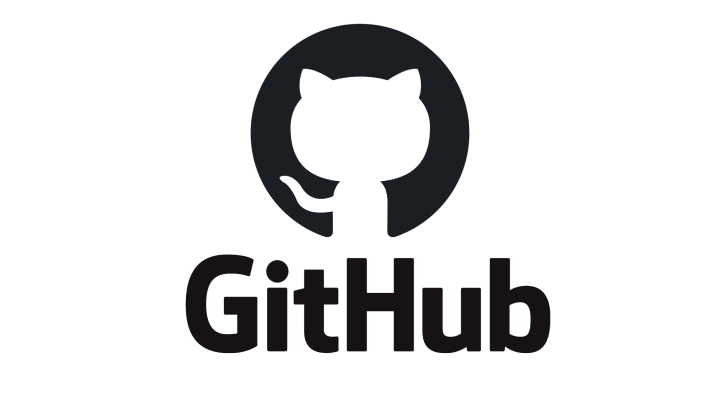
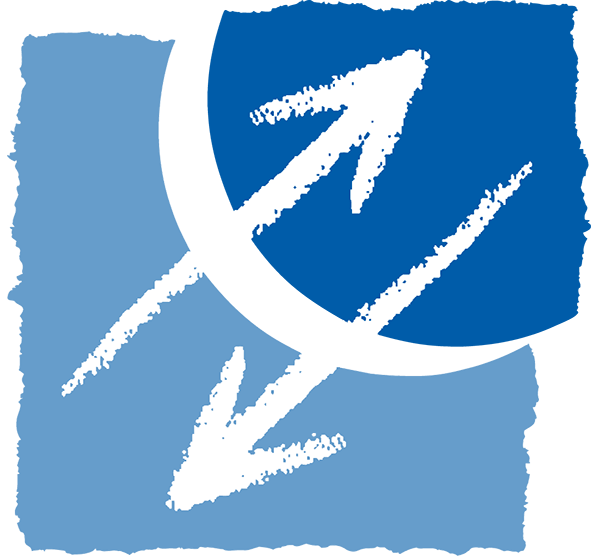
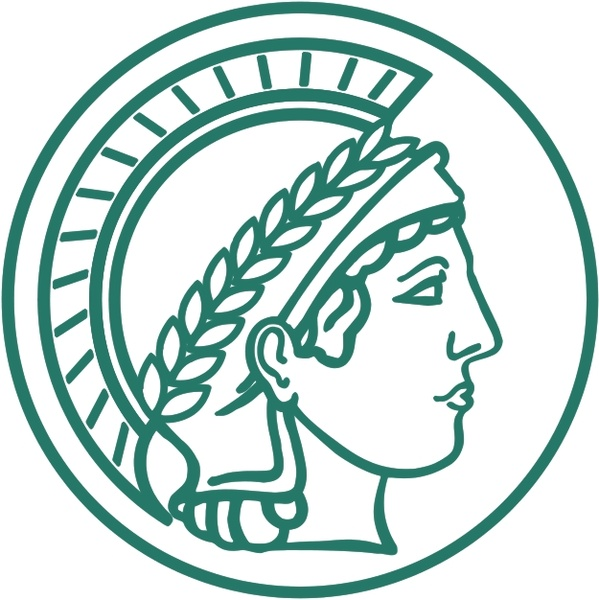

In [301]:
layout = pn.Column(
    header,
    main_part, 
    pn.Row(
        show_settings,
        show_plots,
    ),
)
layout.servable()

In [2]:
class Option_Stack(object):
    
    def __init__(self, option_name, option_initial_value):
        self._stack = [option_initial_value]
        self._stack_pointer = 0
        self._option_name = option_name

    @property
    def current_value(self):
        return self._stack[self._stack_pointer]
    
    @property
    def size(self):
        return len(self._stack) - 1
    
    @property
    def option_name(self):
        return self._option_name
    
    def update(self, option_value):
        if self.current_value != option_value:
            self.trim()
            self._stack.append(option_value)
            self._stack_pointer += 1
            return True
        return False
            
    def redo(self):
        if self._stack_pointer < self.size:
            self._stack_pointer += 1
            return True
        return False
    
    def undo(self):
        if self._stack_pointer > 0:
            self._stack_pointer -= 1
            return True
        return False
    
    def trim(self):
        if self._stack_pointer != self.size:
            self._stack = self._stack[:self._stack_pointer + 1]
    
    def __str__(self):
        return f"{self._stack_pointer} {self._option_name} {self._stack}"

    
class Global_Stack(object):
    
    def __init__(self, all_available_options):
        self._option_stacks = {
            option_key: Option_Stack(
                option_key,
                option_value
            ) for option_key, option_value in all_available_options.items()
        }
        self._number_of_options = len(all_available_options)
        self._stack_pointer = 0
        self._stack = [None]
        
    @property
    def current_values(self):
        return {
            option_key: option_stack.current_value for (
                option_key,
                option_stack
            ) in self._option_stacks.items()
        }

    @property
    def size(self):
        return len(self._stack) - 1

    def update(self, option_key, option_value):
        current_value = self.current_values[option_key]
        if current_value == option_value:
            return ""
        self._option_stacks[option_key].update(option_value)
        self.trim()
        self._stack_pointer += 1
        self._stack.append(option_key)
        return option_key

    def redo(self):
        if self._stack_pointer < self.size:
            option_key = self._stack[self._stack_pointer]
            self._option_stacks[option_key].redo()
            self._stack_pointer += 1
            return option_key
        return ""
    
    def undo(self):
        if self._stack_pointer > 0:
            self._stack_pointer -= 1
            option_key = self._stack[self._stack_pointer]
            self._option_stacks[option_key].undo()
            return option_key
        return ""
    
    def trim(self):
        if self._stack_pointer != self.size:
            self._stack = self._stack[:self._stack_pointer + 1]
            for stack in self._option_stacks.values():
                stack.trim()
    
    def __str__(self):
        result = "\n".join(
            [
                str(stack) for stack in self._option_stacks.values()
            ]
        )
        values = str(self.current_values)
        return result + "\n" + values + " ".join(
            [
                "\n",
                str(self._stack_pointer),
                "global",
                str(self._stack)
            ]
        )
    
        
# @pn.depends(
#     frame_slider.param.value,
#     frames_start.param.value,
#     frames_end.param.value,
#     scan_slider.param.value,
#     scan_start.param.value,
#     scan_end.param.value,
#     watch=True,
# )
# def update_option(*args):
#     option_key = ''
#     option_value = ''
#     updated_option = stack.update(option_key, option_value)
#     update_all_frame_widgets(updated_option)

# @pn.depends(
#     redo_button.param.clicks,
#     watch=True,
# )
# def redo(*args, **kwargs):
#     updated_option = stack.redo()
#     update_all_frame_widgets(updated_option)
    
# @pn.depends(
#     undo_button.param.clicks,
#     watch=True,
# )
# def undo(*args, **kwargs):
#     updated_option = stack.undo()
#     update_all_frame_widgets(updated_option)
    
# def update_all_frame_widgets(updated_option):
#     if updated_option == "":
#         pass
#     pass

In [4]:
def test_option_stack():
    value1 = (1, 920)
    value2 = (300, 920)
    value3 = (500, 600)
    scan_stack = Option_Stack('scans_slider', value1)
    assert str(scan_stack) == f'0 scans_slider [{value1}]', \
    "The initial creation of the class is wrong."
    scan_stack.update(value2)
    assert str(scan_stack) == f'1 scans_slider [{value1}, {value2}]', \
    "The update of the class instance with a new value doesn't work."
    scan_stack.update(value2)
    assert str(scan_stack) == f'1 scans_slider [{value1}, {value2}]', \
    "The update of the class instance with the same value doesn't work."
    scan_stack.undo()
    assert str(scan_stack) == f'0 scans_slider [{value1}, {value2}]', \
    "Undo function doesn't work correctly."
    scan_stack.update(value3)
    assert str(scan_stack) == f'1 scans_slider [{value1}, {value3}]', \
    "Update of the values doesn't work after Undo function."
    scan_stack.undo()
    scan_stack.redo()
    assert str(scan_stack) == f'1 scans_slider [{value1}, {value3}]', \
    "Redo function doesn't work correctly."
test_option_stack()

In [ ]:
# def test_global_stack():
#     stack = Global_Stack(
#         {
#             "a": 1,
#             "b": 9999,
#         }
#     )
#     print(f"Init\n{stack}\n")
#     stack.update("a", 2)
#     print(f"a 2\n{stack}\n")
#     stack.update("a", 2)
#     print(f"a 2\n{stack}\n")
#     stack.update("a", 3)
#     print(f"a 3\n{stack}\n")
#     stack.update("b", 100)
#     print(f"b 100\n{stack}\n")
#     stack.update("a", 9999)
#     print(f"a 9999\n{stack}\n")
#     stack.undo()
#     print(f"UNDO\n{stack}\n")
#     stack.redo()
#     print(f"REDO\n{stack}\n")
#     stack.undo()
#     print(f"UNDO\n{stack}\n")
#     stack.update("b", 20)
#     print(f"a 20\n{stack}\n")
    
# test_global_stack()

In [ ]:
# print(DATASET)

In [ ]:
# import alphatims.utils
# import alphatims.bruker

# file = 'D:/Bruker/20201207_tims03_Evo03_PS_SA_HeLa_200ng_EvoSep_prot_DDA_21min_8cm_S1-C10_1_22476.d'
# data = alphatims.bruker.TimsTOF(file)

# if select_precursors.value:
#     quad_values = (-1, 1)

# selected_indices = data[slice(*frame_slider.value), slice(*scan_slider.value), slice(*quad_values), slice(*tof_slider.value)]

# df = data.as_dataframe(selected_indices)
# df

# import sys
# print(f"The size of Bruker object is {sys.getsizeof(DATASET)} bytes.")

# print(df.mobility_values.nunique())

# im_intensities = data.bin_intensities(selected_indices, ['mobility'])
# print(len(im_intensities))

# type(im_intensities[im_intensities > 0])

# from matplotlib import pyplot as plt
# low_mz_value = 621.9
# high_mz_value = 622.1
# # raw_indices = data[1:100, :, :, low_mz_value:high_mz_value]
# raw_indices = data[1:100, :, :, 188703:188754]
# df1 = data.as_dataframe(raw_indices)
# im_intensities = data.bin_intensities(raw_indices, ['mobility'])

# im_intensities = data.bin_intensities(raw_indices, ['mobility'])
# im_intensities_sorted = [(_,x) for _, x in sorted(zip(df.mobility_values.unique(), im_intensities[im_intensities>0]), key=lambda pair: pair[0])]

# im_intensities_sorted

# hv.Curve(
#     (im_intensities_sorted)[::4]
# ).opts(width=800, height=400)


In [ ]:
# df1

In [ ]:
# im_intensities = data.bin_intensities(raw_indices, ['mobility'])

In [ ]:
# sorted(df1.mobility_values.unique(), reverse=True)

In [ ]:
# df1[df1.mobility_values == 0.8136852968855308].intensity_values.sum()

In [ ]:
# im_intensities[im_intensities>0]